## The Darcy's equation
We consider the following Darcy flows in a 2D area filled with porous materials. The governing PDE is 
$$
-\nabla( K(x,y) \nabla P(x,y)) = f(x,y), \quad x\in\Omega
$$  
where $K$ is the permeability field, $P$ is the pressure, and $f$ is a source term which can be either a constant or a space-dependent function.
### (1.1) Neural Operator learning problem

The first example of Darcy flow is defined in a rectangular domain $\Omega=[0,1]^2$ with zero Dirichlet boundary condition. We are interested in learning the mapping from the permeability field $K(x,y)$ to the pressure field $P(x,y)$, i.e.,
$$
\mathcal{G}: K(x,y) \rightarrow P(x,y)
$$

## (2) The Deep Generative Neural Operator (DGNO)

### (2.1) Prepare data

In [4]:
import sys 
sys.path.append("../..") 
import numpy as np
import h5py
import torch 
import matplotlib.pyplot as plt
#
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
random_seed = 1234
setup_seed(random_seed)
device = 'cuda:0'
dtype = torch.float32
problem_name = 'DarcyFlow_pwc2d'
tag = 'tanhBeta128'
######################################
# Load training data
######################################
data_train = h5py.File('../../Problems/DarcyFlow_2d/pwc_train.mat', 'r')
data_test = h5py.File('../../Problems/DarcyFlow_2d/pwc_test_in.mat', 'r')
print(data_train.keys())
print(data_test.keys())
res = 29
######################################
from Utils.utils import *
n_train, n_test = 1000, 200
#
def get_data(data, ndata, dtype, n0=0):
    a = np2tensor(np.array(data["coeff"][...,n0:n0+ndata]).T, dtype)
    a[a==1.] = 10.; a[a==0.] = 5.;
    u = np2tensor(np.array(data["sol_fem"][...,n0:n0+ndata]).T, dtype)
    #
    try:
        X, Y = np.array(data['X_sol']).T, np.array(data['Y_sol']).T
        mesh = np2tensor(np.vstack([X.ravel(), Y.ravel()]).T, dtype)
        gridx = mesh.reshape(-1, 2)
    except:
        X, Y = np.array(data['X']).T, np.array(data['Y']).T
        mesh = np2tensor(np.vstack([X.ravel(), Y.ravel()]).T, dtype)
        gridx = mesh.reshape(-1, 2)
    #
    x = gridx.repeat((ndata, 1, 1))
    a = a.reshape(ndata, -1, 1)
    u = u.reshape(ndata, -1, 1)
    
    return a, u, x, gridx
#
a_train, u_train, x_train, grid_train = get_data(data_train, n_train, dtype)
a_test, u_test, x_test, grid_test = get_data(data_test, n_test, dtype)
#
print('The shape of x_train:', x_train.shape)
print('The shape of a_train:', a_train.shape)
print('The shape of u_train:', u_train.shape)
print('The shape of grid_train:', grid_train.shape)
print('The shape of x_test:', x_test.shape)
print('The shape of a_test:', a_test.shape)
print('The shape of u_test:', u_test.shape)
print('The shape of grid_test:', grid_test.shape)

<KeysViewHDF5 ['X', 'Y', 'coeff', 'sol_fdm', 'sol_fem']>
<KeysViewHDF5 ['X', 'Y', 'coeff', 'sol_fdm', 'sol_fem']>
The shape of x_train: torch.Size([1000, 841, 2])
The shape of a_train: torch.Size([1000, 841, 1])
The shape of u_train: torch.Size([1000, 841, 1])
The shape of grid_train: torch.Size([841, 2])
The shape of x_test: torch.Size([200, 841, 2])
The shape of a_test: torch.Size([200, 841, 1])
The shape of u_test: torch.Size([200, 841, 1])
The shape of grid_test: torch.Size([841, 2])


### (2.2) Define the loss class

In [5]:
import torch.nn as nn
from torch.autograd import grad, Variable
from Utils.GenPoints import Point2D
from Utils.TestFun_ParticleWNN import TestFun_ParticleWNN
###############################
# The test function
###############################
pointGen = Point2D(x_lb=[0., 0.], x_ub=[1.,1.], dataType=dtype, random_seed=random_seed)
#
int_grid, v, dv_dr = TestFun_ParticleWNN(
    fun_type='Wendland', dim=2, n_mesh_or_grid=7, dataType=dtype).get_testFun()
print('int_grid shape:', int_grid.shape, 'v shape:', v.shape)

########################################
class fun_a(object):

    def __init__(self, res):
        super(fun_a, self).__init__()
        self.res = res
        self.delta = 1./(res-1)

    def __call__(self, x, a):
        a = a.squeeze(-1)
        x_loc = torch.floor(x[...,0] / self.delta + 0.5).int()
        y_loc = torch.floor(x[...,1] / self.delta + 0.5).int()
        loc = y_loc * self.res + x_loc
        #
        img = a[torch.arange(a.size(0)).unsqueeze(1), loc]
        
        return img.unsqueeze(-1)
###############################
class mollifer(object):

    def __inint__(self):
        super(mollifer, self).__init_()
        
    def __call__(self, u, x):
        xx, yy = x[...,0:1], x[...,1:2]
        u = u * torch.sin(np.pi * xx)*torch.sin(np.pi * yy) 

        return u
        
################################
class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        ''' '''
        self.solver = solver
        self.dtype = solver.dtype
        self.device = solver.device
        self.mollifer = mollifer()
        self.fun_a = fun_a(res=res)
        self.model_a = solver.model_dict['a']
        self.model_u = solver.model_dict['u']
        self.model_s1 = solver.model_dict['s1']
        self.model_s2 = solver.model_dict['s2']
        self.model_enc = solver.model_dict['enc']
        #######################
        self.int_grid = int_grid.to(self.device)
        self.n_grid = int_grid.shape[0]
        self.v = v.to(self.device)
        self.dv_dr = dv_dr.to(self.device)

    def Loss_pde(self, a_batch, w_pde, nc=300):
        beta = self.model_enc(a_batch)
        #
        if w_pde>0.:
            n_batch = a_batch.shape[0]
            ############### Data points ###############
            xc, R = pointGen.weight_centers(n_center=nc, R_max=1e-4, R_min=1e-4)
            xc, R = xc.to(self.device), R.to(self.device)
            nc = xc.shape[0]
            x = self.int_grid * R + xc
            x = x.reshape(-1, 2).repeat((n_batch,1,1))
            x = Variable(x, requires_grad=True)
            ############### Test functions #############
            v = self.v.repeat((nc,1,1)).reshape(-1, 1)
            dv = (self.dv_dr / R).reshape(-1, 2)
            ################ model prediction ###########
            a_detach = self.fun_a(x.detach(), a_batch) 
            u = self.model_u(x, beta)
            u = self.mollifer(u, x)
            s = torch.cat([self.model_s1(x, beta), self.model_s2(x, beta)], dim=-1)
            du = grad(inputs=x, outputs=u, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            f = 10. * torch.ones_like(u)
            ################ PDE loss #################### 
            res1 = torch.sum( (s - a_detach * du)**2, dim=-1).reshape(n_batch, nc, self.n_grid)
            res1 = torch.mean(res1, dim=-1)
            #
            left = torch.sum(s * dv, dim=-1).reshape(n_batch, nc, self.n_grid)
            left = torch.mean(left, dim=-1)
            #
            right = (f*v).reshape(n_batch, nc, self.n_grid)
            right = torch.mean(right, dim=-1)
            res2 = (left-right)**2

            return torch.mean(res1) + torch.mean(res2) * np.sqrt(nc) 
        else:
            return torch.tensor(0.)
        
    def Loss_data(self, x, a, u, w_data):
        if w_data>0.:
            beta = self.model_enc(a)
            a_pred = nn.Sigmoid()(self.model_a(x, beta))
            a_true = (a-5.)/5.
            return nn.functional.binary_cross_entropy(a_pred, a_true, reduction='mean')
        else:
            return torch.tensor(0.)

    def Error(self, x, a, u):
        beta = self.model_enc(a)
        u_pred = self.model_u(x, beta)
        u_pred = self.mollifer(u_pred, x)

        return self.solver.getError(u_pred, u)
        
######################################
# Steups of the model
######################################
from Solvers.DGNO import DGNO
solver = DGNO.Solver(device=device, dtype=dtype)
netType = 'MultiONetBatch' # for u model
beta_size = 128      

####################################### The beta model
from Networks.EncoderNet import EncoderCNNet2d
class Encoder(nn.Module):
    def __init__(self, conv_arch:list, fc_arch:list, 
                 act_conv, act_fc,
                 nx_size:int, ny_size:int, dtype=None):
        super(Encoder, self).__init__()
        self.conv = EncoderCNNet2d(conv_arch=conv_arch, fc_arch=fc_arch,
                                   activation_conv=act_conv, activation_fc=act_fc,
                                   nx_size=nx_size, ny_size=ny_size, 
                                   kernel_size=(3,3), stride=2, dtype=dtype)
        
    def forward(self, x):
        x = self.conv(x)
        x = torch.tanh(x)
        
        return x
#
conv_arch, act_conv = [1, 64, 64, 64], 'SiLU'
fc_arch, act_fc = [64*2*2, 128, 128, beta_size], 'SiLU'
model_enc = Encoder(conv_arch, fc_arch, act_conv, act_fc,
                    nx_size=res, ny_size=res, dtype=dtype).to(device)

###################################### The u model
hidden_list, act_x, act_a = [80]*6, 'Tanh_Sin', 'Tanh_Sin'
model_u = solver.getModel(x_in_size=2, a_in_size=beta_size, 
                          hidden_list=hidden_list, activation_x=act_x, activation_a=act_a, 
                          netType=netType)
model_s1 = solver.getModel(x_in_size=2, a_in_size=beta_size,
                          hidden_list=hidden_list, activation_x=act_x, activation_a=act_a, 
                          netType=netType)
model_s2 = solver.getModel(x_in_size=2, a_in_size=beta_size,
                          hidden_list=hidden_list, activation_x=act_x, activation_a=act_a, 
                          netType=netType)
model_a = solver.getModel(x_in_size=2, a_in_size=beta_size,
                          hidden_list=hidden_list, activation_x=act_x, activation_a=act_a, 
                          netType=netType)

# ###############################
total_trainable_params_enc = sum(p.numel() for p in model_enc.parameters() if p.requires_grad)
print(f'{total_trainable_params_enc:,} training parameters.')
########
total_trainable_params_u = sum(p.numel() for p in model_u.parameters() if p.requires_grad)
print(f'{total_trainable_params_u:,} training parameters.')
#
print(f'{total_trainable_params_enc + total_trainable_params_u:,} total parameters')

int_grid shape: torch.Size([25, 2]) v shape: torch.Size([25, 1])
140,416 training parameters.
88,332 training parameters.
228,748 total parameters


### (2.3) training and make prediction

#### (2.3.1) train the model

In [ ]:
model_dict = {'u':model_u, 's1':model_s1, 's2':model_s2, 'a':model_a, 'enc':model_enc}
solver.train_setup(model_dict, lr=5e-4, optimizer='Adam', scheduler_type='StepLR', 
                   gamma=0.6, step_size=1000)
solver.train(LossClass, a_train, u_train, x_train, a_test, u_test, x_test, 
             w_data=0.25, w_pde=1., batch_size=50, epochs=10000, epoch_show=50,
             **{'save_path':f'saved_models/DGNO_{tag}/'})

#### (2.3.2) make prediction

The shape of a_test: torch.Size([200, 841, 1]) a_pred: torch.Size([200, 841, 1])
The shape of u_test: torch.Size([200, 841, 1]) u_pred: torch.Size([200, 841, 1])
The shape of beta_test: torch.Size([200, 128])
The test loss (avg): tensor(0.0334)
The test l2 error (avg): tensor(0.0207)


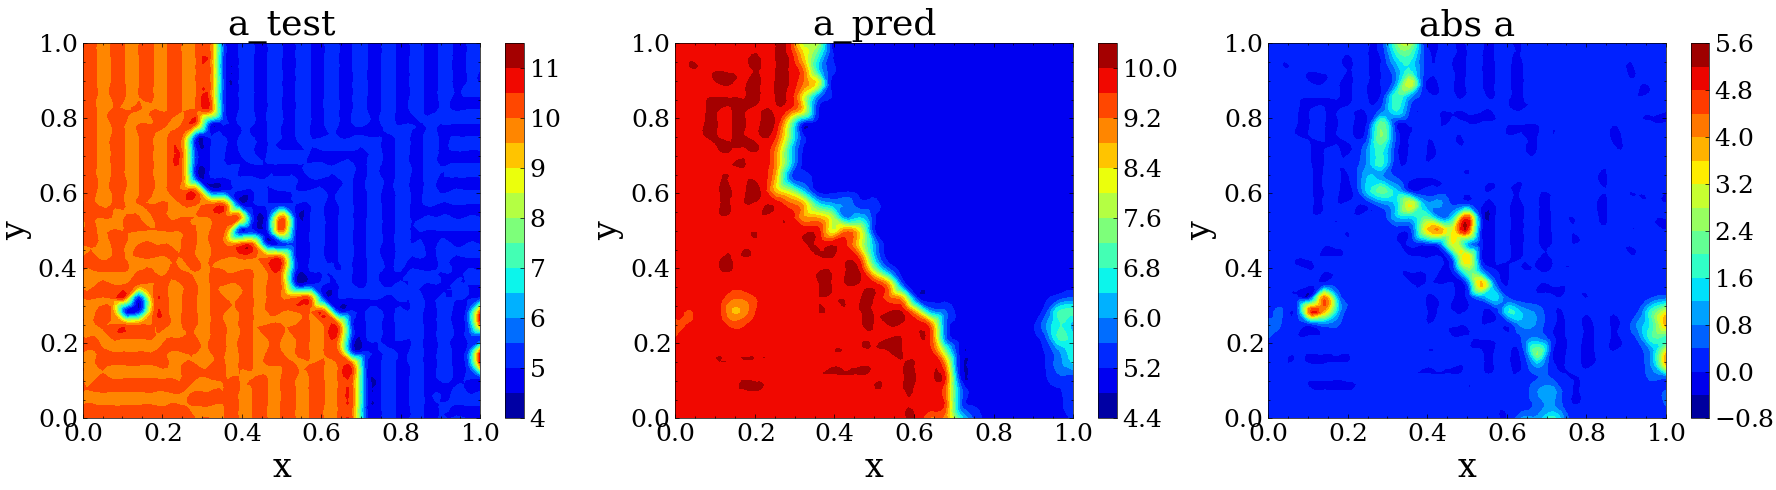

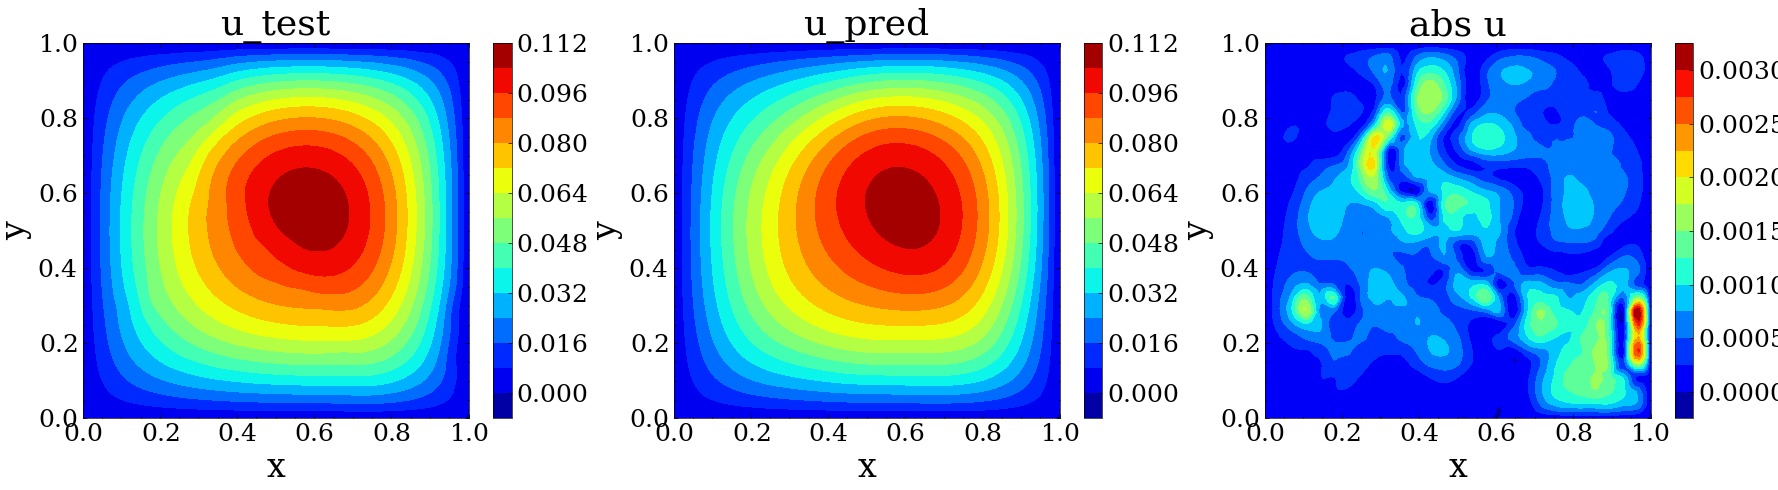

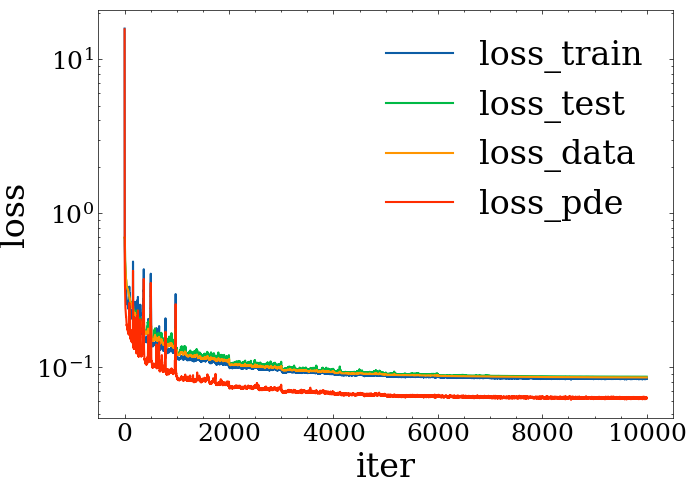

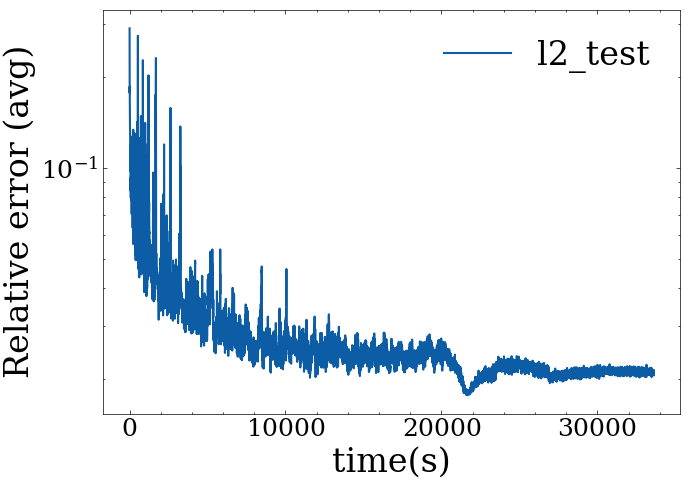

In [6]:
# #####################################
# # Load the trained model
# #####################################
from Solvers.DGNO import DGNO
solver = DGNO.Solver(device=device, dtype=dtype)
tag = 'tanhBeta128'
model_trained = solver.loadModel(path=f'saved_models/DGNO_{tag}/', name=f'model_dgno_final')
#########################################
def a_sample(a_prob, samples=10):
    a = torch.zeros_like(a_prob)
    for i in range(samples):
        eps = torch.rand_like(a_prob)
        a += torch.log(eps) - torch.log(1-eps) + torch.log(a_prob+1e-8) - torch.log(1-a_prob+1e-8)
    a = nn.Sigmoid()(a/samples)*5. + 5.
    
    return a
#########################################
x_coe = grid_train.repeat(x_test.shape[0], 1, 1).to(device)
x_var = x_test.to(device)
beta_pred = model_trained['enc'](a_test.to(device))
u_pred = model_trained['u'](x_var, beta_pred)
u_pred = mollifer()(u_pred, x_var)
#
a_pred = nn.Sigmoid()(model_trained['a'](x_coe, beta_pred))
a_pred = a_sample(a_pred)
#
u_pred, a_pred, beta_pred = u_pred.detach().cpu(), a_pred.detach().cpu(), beta_pred.detach().cpu()
#
print('The shape of a_test:', a_test.shape, 'a_pred:', a_pred.shape)
print('The shape of u_test:', u_test.shape, 'u_pred:', u_pred.shape)
print('The shape of beta_test:', beta_pred.shape)
print('The test loss (avg):', solver.getLoss(u_pred, u_test))
print('The test l2 error (avg):', solver.getError(u_pred, u_test))
inx = 0
# # ########################################
from Utils.PlotFigure import Plot
Plot.show_2d_list(grid_train, [a_test[inx], a_pred[inx], torch.abs(a_test[inx]-a_pred[inx])], 
                  ['a_test', 'a_pred', 'abs a'], lb =0.)
Plot.show_2d_list(grid_test, [u_test[inx], u_pred[inx], torch.abs(u_test[inx]-u_pred[inx])], 
                  [ 'u_test', 'u_pred', 'abs u'], lb =0.)
#############################################
# show loss
loss_saved = solver.loadLoss(path=f'saved_models/DGNO_{tag}/', name='loss_dgno')
Plot.show_loss([loss_saved['loss_train'], loss_saved['loss_test'], loss_saved['loss_data'], loss_saved['loss_pde']], 
               ['loss_train', 'loss_test', 'loss_data', 'loss_pde'])
# show error
Plot.show_error([loss_saved['time']]*1, [loss_saved['error']], ['l2_test'])